In [1]:
import logging
import torch
import numpy as np
import pylab as plt
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import pyro.poutine as poutine

First we define our forward model. This is a simple temperature-index model (also known as postitive degree-day model, PDD). In short, the model calculates annual surface mass balance `smb` and its components accumulation `accu`, melt `melt`, and refreeze `refreeze` from temperature `temp` and precipitation `prec`. It has tunable parameters `pdd_factor_snow`, `pdd_factor_ice` and `refreeze`.

In [2]:
class TorchPDDModel(pyro.nn.module.PyroModule):
    """

    # Copyright (c) 2013--2018, Julien Seguinot <seguinot@vaw.baug.ethz.ch>
    # GNU General Public License v3.0+ (https://www.gnu.org/licenses/gpl-3.0.txt)

    A positive degree day model for glacier surface mass balance

    Return a callable Positive Degree Day (PDD) model instance.

    Model parameters are held as public attributes, and can be set using
    corresponding keyword arguments at initialization time:

    *pdd_factor_snow* : float
        Positive degree-day factor for snow.
    *pdd_factor_ice* : float
        Positive degree-day factor for ice.
    *refreeze_snow* : float
        Refreezing fraction of melted snow.
    *refreeze_ice* : float
        Refreezing fraction of melted ice.
    *temp_snow* : float
        Temperature at which all precipitation falls as snow.
    *temp_rain* : float
        Temperature at which all precipitation falls as rain.
    *interpolate_rule* : [ 'linear' | 'nearest' | 'zero' |
                           'slinear' | 'quadratic' | 'cubic' ]
        Interpolation rule passed to `scipy.interpolate.interp1d`.
    *interpolate_n*: int
        Number of points used in interpolations.
    """

    def __init__(
        self,
        pdd_factor_snow=3,
        pdd_factor_ice=8,
        refreeze_snow=0.0,
        refreeze_ice=0.0,
        temp_snow=0.0,
        temp_rain=2.0,
        interpolate_rule="linear",
        interpolate_n=52,
        *args,
        **kwargs,
    ):
        super().__init__()

        # set pdd model parameters
        self.pdd_factor_snow = pdd_factor_snow
        self.pdd_factor_ice = pdd_factor_ice
        self.refreeze_snow = refreeze_snow
        self.refreeze_ice = refreeze_ice
        self.temp_snow = temp_snow
        self.temp_rain = temp_rain
        self.interpolate_rule = interpolate_rule
        self.interpolate_n = interpolate_n

    def forward(self, temp, prec, stdv=0.0):
        """Run the positive degree day model.

        Use temperature, precipitation, and standard deviation of temperature
        to compute the number of positive degree days, accumulation and melt
        surface mass fluxes, and the resulting surface mass balance.

        *temp*: array_like
            Input near-surface air temperature in degrees Celcius.
        *prec*: array_like
            Input precipitation rate in meter per year.
        *stdv*: array_like (default 0.0)
            Input standard deviation of near-surface air temperature in Kelvin.

        By default, inputs are N-dimensional arrays whose first dimension is
        interpreted as time and as periodic. Arrays of dimensions
        N-1 are interpreted as constant in time and expanded to N dimensions.
        Arrays of dimension 0 and numbers are interpreted as constant in time
        and space and will be expanded too. The largest input array determines
        the number of dimensions N.

        Return the number of positive degree days ('pdd'), surface mass balance
        ('smb'), and many other output variables in a dictionary.
        """

        # ensure numpy arrays
        temp = torch.asarray(temp)
        prec = torch.asarray(prec)
        stdv = torch.asarray(stdv)

        # expand arrays to the largest shape
        maxshape = max(temp.shape, prec.shape, stdv.shape)
        temp = self._expand(temp, maxshape)
        prec = self._expand(prec, maxshape)
        stdv = self._expand(stdv, maxshape)

        # interpolate time-series
        if self.interpolate_n >= 1:
            temp = self._interpolate(temp)
            prec = self._interpolate(prec)
            stdv = self._interpolate(stdv)

        # compute accumulation and pdd
        accu_rate = self.accu_rate(temp, prec)
        inst_pdd = self.inst_pdd(temp, stdv)

        # initialize snow depth, melt and refreeze rates
        snow_depth = torch.zeros_like(temp)
        snow_melt_rate = torch.zeros_like(temp)
        ice_melt_rate = torch.zeros_like(temp)
        snow_refreeze_rate = torch.zeros_like(temp)
        ice_refreeze_rate = torch.zeros_like(temp)

        snow_depth[:-1] = torch.clone(snow_depth[1:])
        snow_depth = snow_depth + accu_rate
        snow_melt_rate, ice_melt_rate = self.melt_rates(snow_depth, inst_pdd)
        snow_depth = snow_depth - snow_melt_rate

        melt_rate = snow_melt_rate + ice_melt_rate
        snow_refreeze_rate = self.refreeze_snow * snow_melt_rate
        ice_refreeze_rate = self.refreeze_ice * ice_melt_rate
        refreeze_rate = snow_refreeze_rate + ice_refreeze_rate
        runoff_rate = melt_rate - refreeze_rate
        inst_smb = accu_rate - runoff_rate

        # output
        return {
            "temp": temp,
            "prec": prec,
            "stdv": stdv,
            "inst_pdd": inst_pdd,
            "accu_rate": accu_rate,
            "snow_melt_rate": snow_melt_rate,
            "ice_melt_rate": ice_melt_rate,
            "melt_rate": melt_rate,
            "snow_refreeze_rate": snow_refreeze_rate,
            "ice_refreeze_rate": ice_refreeze_rate,
            "refreeze_rate": refreeze_rate,
            "runoff_rate": runoff_rate,
            "inst_smb": inst_smb,
            "snow_depth": snow_depth,
            "pdd": self._integrate(inst_pdd),
            "accu": self._integrate(accu_rate),
            "snow_melt": self._integrate(snow_melt_rate),
            "ice_melt": self._integrate(ice_melt_rate),
            "melt": self._integrate(melt_rate),
            "runoff": self._integrate(runoff_rate),
            "refreeze": self._integrate(refreeze_rate),
            "smb": self._integrate(inst_smb),
        }

    def _expand(self, array, shape):
        """Expand an array to the given shape"""
        if array.shape == shape:
            res = array
        elif array.shape == (1, shape[1], shape[2]):
            res = np.asarray([array[0]] * shape[0])
        elif array.shape == shape[1:]:
            res = np.asarray([array] * shape[0])
        elif array.shape == ():
            res = array * torch.ones(shape)
        else:
            raise ValueError(
                "could not expand array of shape %s to %s" % (array.shape, shape)
            )
        return res

    def _integrate(self, array):
        """Integrate an array over one year"""
        return torch.sum(array, axis=0) / (self.interpolate_n - 1)

    def _interpolate(self, array):
        """Interpolate an array through one year."""

        from scipy.interpolate import interp1d

        rule = self.interpolate_rule
        npts = self.interpolate_n
        oldx = (torch.arange(len(array) + 2) - 0.5) / len(array)
        oldy = torch.vstack((array[-1], array, array[0]))
        newx = (torch.arange(npts) + 0.5) / npts  # use 0.0 for PISM-like behaviour
        newy = interp1d(oldx, oldy, kind=rule, axis=0)(newx)

        return torch.from_numpy(newy)

    def inst_pdd(self, temp, stdv):
        """Compute instantaneous positive degree days from temperature.

        Use near-surface air temperature and standard deviation to compute
        instantaneous positive degree days (effective temperature for melt,
        unit degrees C) using an integral formulation (Calov and Greve, 2005).

        *temp*: array_like
            Near-surface air temperature in degrees Celcius.
        *stdv*: array_like
            Standard deviation of near-surface air temperature in Kelvin.
        """

        # compute positive part of temperature everywhere
        positivepart = torch.greater(temp, 0) * temp

        # compute Calov and Greve (2005) integrand, ignoring division by zero
        normtemp = temp / (torch.sqrt(torch.tensor(2)) * stdv)
        calovgreve = stdv / torch.sqrt(torch.tensor(2) * torch.pi) * torch.exp(
            -(normtemp**2)
        ) + temp / 2 * torch.erfc(-normtemp)

        # use positive part where sigma is zero and Calov and Greve elsewhere
        teff = torch.where(stdv == 0.0, positivepart, calovgreve)

        # convert to degree-days
        return teff * 365.242198781

    def accu_rate(self, temp, prec):
        """Compute accumulation rate from temperature and precipitation.

        The fraction of precipitation that falls as snow decreases linearly
        from one to zero between temperature thresholds defined by the
        `temp_snow` and `temp_rain` attributes.

        *temp*: array_like
            Near-surface air temperature in degrees Celcius.
        *prec*: array_like
            Precipitation rate in meter per year.
        """

        # compute snow fraction as a function of temperature
        reduced_temp = (self.temp_rain - temp) / (self.temp_rain - self.temp_snow)
        snowfrac = torch.clip(reduced_temp, 0, 1)

        # return accumulation rate
        return snowfrac * prec

    def melt_rates(self, snow, pdd):
        """Compute melt rates from snow precipitation and pdd sum.

        Snow melt is computed from the number of positive degree days (*pdd*)
        and the `pdd_factor_snow` model attribute. If all snow is melted and
        some energy (PDD) remains, ice melt is computed using `pdd_factor_ice`.

        *snow*: array_like
            Snow precipitation rate.
        *pdd*: array_like
            Number of positive degree days.
        """

        # parse model parameters for readability
        ddf_snow = self.pdd_factor_snow / 1e3
        ddf_ice = self.pdd_factor_ice / 1e3

        # compute a potential snow melt
        pot_snow_melt = ddf_snow * pdd

        # effective snow melt can't exceed amount of snow
        snow_melt = torch.minimum(snow, pot_snow_melt)

        # ice melt is proportional to excess snow melt
        ice_melt = (pot_snow_melt - snow_melt) * ddf_ice / ddf_snow

        # return melt rates
        return (snow_melt, ice_melt)


Let's create some fake monthly input data

In [3]:
n = 10
m = 12


lx = ly = 750000
x = np.linspace(-lx, lx, n)
y = np.linspace(-ly, ly, n)
t  = (np.arange(12)+0.5) / 12

# assign temperature and precipitation values
(yy, xx) = np.meshgrid(y, x)
temp = np.zeros((m, n, n))
prec = np.zeros((m, n, n))
stdv = np.zeros((m, n, n))
for i in range(len(t)):
    temp[i] = -10 * yy / ly - 5 * np.cos(i * 2 * np.pi / 12)
    prec[i] = xx / lx * (np.sign(xx) - np.cos(i * 2 * np.pi / 12))
    stdv[i] = (2 + xx / lx - yy / ly) * (1 - np.cos(i * 2 * np.pi / 12))

T_obs = temp.reshape(m, -1)
P_obs = prec.reshape(m, -1)
std_dev = stdv.reshape(m, -1)

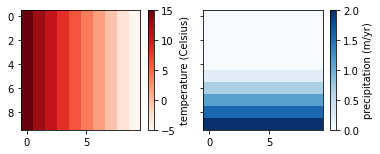

In [4]:
fig, axs = plt.subplots(
    1,
    2,
    sharey="row",
    figsize=[6.0, 2.2],
)
t = axs[0].imshow(temp[6], cmap="Reds")
p = axs[1].imshow(prec[6], cmap="Blues")
ct = fig.colorbar(t, ax=axs[0])
ct.set_label("temperature (Celsius)")
cp = fig.colorbar(p, ax=axs[1])
cp.set_label("precipitation (m/yr)")

Run the forward model to calculate surface mass balance and its component for fixed parameters. We will use the result as our observations.

In [5]:
pdd = TorchPDDModel(
    pdd_factor_snow=3,
    pdd_factor_ice=8,
    refreeze_snow=0.0,
    refreeze_ice=0.0,
)
result = pdd(T_obs, P_obs, std_dev)

B_obs = result["smb"]
A_obs = result["accu"]
M_obs = result["melt"]
R_obs = result["refreeze"]

Plot the "observations"

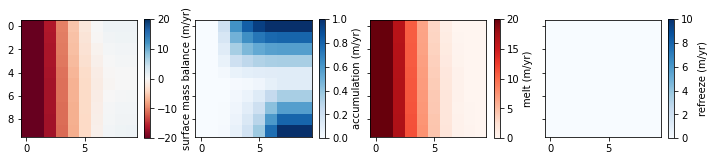

In [6]:
fig, axs = plt.subplots(
    1,
    4,
    sharey="row",
    figsize=[12.0, 2.2],
)
ba = axs[0].imshow(B_obs.reshape(n, n), cmap="RdBu", vmin=-20, vmax=20)
cb = fig.colorbar(ba, ax=axs[0])
cb.set_label("surface mass balance (m/yr)")

aa = axs[1].imshow(A_obs.reshape(n, n), cmap="Blues", vmin=0, vmax=1)
ca = fig.colorbar(aa, ax=axs[1])
ca.set_label("accumulation (m/yr)")

ma = axs[2].imshow(M_obs.reshape(n, n), cmap="Reds", vmin=0, vmax=20)
cm = fig.colorbar(ma, ax=axs[2])
cm.set_label("melt (m/yr)")

ra = axs[3].imshow(R_obs.reshape(n, n), cmap="Blues", vmin=0, vmax=10)
cr = fig.colorbar(ra, ax=axs[3])
cr.set_label("refreeze (m/yr)")



Now define the Pyro model class

In [14]:
class BayesianPDD(pyro.nn.module.PyroModule):
    def __init__(self, use_cuda=False):
        super().__init__()
        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda

    def model(
        self, temp, precip, std_dev, A_obs=None, M_obs=None, R_obs=None, B_obs=None
    ):

        f_snow = pyro.sample("f_snow", dist.Normal(4.1, 1))
        f_ice = pyro.sample("f_ice", dist.Normal(8, 1))
        refreeze = pyro.sample("refreeze", dist.Normal(0.5, 0.2))

        pdd_model = TorchPDDModel(
            pdd_factor_snow=f_snow,
            pdd_factor_ice=f_ice,
            refreeze_snow=refreeze,
            refreeze_ice=refreeze,
        )
        result = pdd_model.forward(temp, precip, std_dev)
        B = result["smb"]
        A = result["accu"]
        M = result["melt"]
        R = result["refreeze"]

        with pyro.plate("obs", use_cuda=self.use_cuda):

            A_sigma = pyro.sample("A_sigma", dist.HalfCauchy(2))
            pyro.sample("A_est", dist.Normal(A, A_sigma).to_event(1), obs=A_obs)
            M_sigma = pyro.sample("M_sigma", dist.HalfCauchy(10))
            pyro.sample("M_est", dist.Normal(M, M_sigma).to_event(1), obs=M_obs)
            R_sigma = pyro.sample("R_sigma", dist.HalfCauchy(0.5))
            pyro.sample("R_est", dist.Normal(R, R_sigma).to_event(1), obs=R_obs)
            B_sigma = pyro.sample("B_sigma", dist.HalfCauchy(10))
            pyro.sample("B_est", dist.Normal(B, B_sigma).to_event(1), obs=B_obs)

            return {
                "f_snow": f_snow,
                "f_ice": f_ice,
                "refreeze": refreeze,
            }

    def guide(
        self, temp, precip, std_dev, A_obs=None, M_obs=None, R_obs=None, B_obs=None
    ):

        f_snow_loc = pyro.param("f_snow_loc", torch.tensor(4.1))
        f_snow_scale = pyro.param(
            "f_snow_scale",
            torch.tensor(1),
            constraint=constraints.positive,
        )

        f_ice_loc = pyro.param("f_ice_loc", torch.tensor(8.0))
        f_ice_scale = pyro.param(
            "f_ice_scale", torch.tensor(1), constraint=constraints.positive
        )
        refreeze_loc = pyro.param(
            "refreeze_loc",
            torch.tensor(0.5),
            constraint=constraints.interval(0.0, 1.0),
        )
        refreeze_scale = pyro.param(
            "refreeze_scale",
            lambda: torch.tensor(0.25),
            constraint=constraints.positive,
        )

        f_snow = pyro.sample("f_snow", dist.Normal(f_snow_loc, f_snow_scale))
        f_ice = pyro.sample("f_ice", dist.Normal(f_ice_loc, f_ice_scale))
        refreeze = pyro.sample("refreeze", dist.Normal(refreeze_loc, refreeze_scale))

        pdd_model = TorchPDDModel(
            pdd_factor_snow=f_snow,
            pdd_factor_ice=f_ice,
            refreeze_snow=refreeze,
            refreeze_ice=refreeze,
        )

        result = pdd_model.forward(temp, precip, std_dev)
        return {
            "f_snow": f_snow,
            "f_ice": f_ice,
            "refreeze": refreeze,
        }

    def forward(
        self, temp, precip, std_dev, A_obs=None, M_obs=None, R_obs=None, B_obs=None
    ):

        pyro.clear_param_store()
        adam = pyro.optim.Adam({"lr": 0.1})  # Consider decreasing learning rate.
        elbo = pyro.infer.Trace_ELBO()
        print("Setting up SVI")
        svi = pyro.infer.SVI(model.model, model.guide, adam, elbo)
        num_iters = 10000
        losses = []
        for i in range(num_iters):
            elbo = svi.step(T_obs, P_obs, np.zeros_like(T_obs), A_obs, M_obs, R_obs)
            losses.append(elbo)
            if i % 1000 == 0:
                print(f"Iteration {i} loss: {elbo}")
                logging.info("Elbo loss: {}".format(elbo))

## Run the inference

We want to recover the parameters f_snow=3, f_ice=8, and refreeze=0

In [29]:
model = BayesianPDD()
model.forward(T_obs, P_obs, std_dev, A_obs, M_obs, R_obs)


Setting up SVI
Iteration 0 loss: 58518.65269007479


/Users/andy/Library/Python/3.9/lib/python/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'B_est', 'R_sigma', 'B_sigma', 'M_sigma', 'A_sigma'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


Iteration 1000 loss: 1009.4111231534679
Iteration 2000 loss: 1746.4648865816393
Iteration 3000 loss: 840.0712056143527
Iteration 4000 loss: 1142.0784400814334
Iteration 5000 loss: 275119.45909379347
Iteration 6000 loss: 1338.1573373836782
Iteration 7000 loss: 1117.6274454339477
Iteration 8000 loss: 730.782338767407
Iteration 9000 loss: 1180.1491724769844


Recovered parameter means

In [30]:
print("Recovered parameters")
for name, value in pyro.get_param_store().items():
    print(name, f"""{pyro.param(name).data.cpu().numpy():.2f}""")

Recovered parameters
f_snow_loc 6.14
f_snow_scale 2.65
f_ice_loc 8.86
f_ice_scale 0.01
refreeze_loc 0.00
refreeze_scale 0.00


Sample from posterior and plot histgrams/KDE

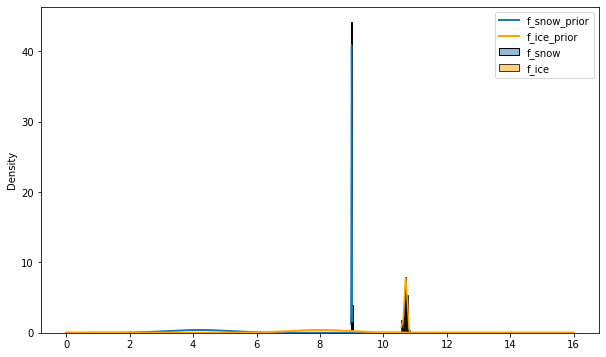

In [28]:
    with pyro.plate("samples", T_obs.shape[1], dim=-1):
        samples = model.guide(
            T_obs,
            P_obs,
            np.zeros_like(T_obs),
        )

    fs = samples["f_snow"]
    fi = samples["f_ice"]
    r = samples["refreeze"]

    import seaborn as sns
    from scipy.stats import norm

    fig = plt.figure(figsize=(10, 6))

    sns.histplot(fs.detach().cpu().numpy(), kde=True, stat="density", label="f_snow")
    sns.histplot(
        fi.detach().cpu().numpy(),
        kde=True,
        stat="density",
        label="f_ice",
        color="orange",
    )
    x = np.arange(0, 16, 0.001)
    plt.plot(x, norm.pdf(x, 4.2, 1), lw=2, label="f_snow_prior")
    plt.plot(x, norm.pdf(x, 8.0, 1), color="orange", lw=2, label="f_ice_prior")
    plt.legend()
    plt.show()


Obviously the inference is not able to recover the original parameters